# Identifying Cells with Optogenetics

In this section, you will learn how to access the optogenetic data within the AllenSDK's Neuropixels dataset. In these experiments, light-gated ion channels were expressed in mice in a Cre-dependent manner. These ion channels can depolarize Cre+ cells when specific wavelengths of light are shined on the brain.

Although it can be hard to identify cell types with extracellular electrophysiology, the integration of optogenetics into these experiments is one way to help identify subsets of cells. Only units with our cre-line of interest will respond to the light allowing for subgroups of neuronal untis to be identified and analyzed across differing genotypes. This technique is called **optotagging**.

**Note**: the presence of light artifacts can create the appearance of false positives, and false negatives (cells that are Cre+ but do not respond to light) are nearly impossible to avoid. We will go over how to deal with these cases later in the notebook. 

In [1]:
# Import necessary packages 
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
import warnings
warnings.filterwarnings('ignore')

# Import the Neuropixels Cache
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_project_api import EcephysProjectWarehouseApi
from allensdk.brain_observatory.ecephys.ecephys_project_api.rma_engine import RmaEngine

# Assign where data will be stored
manifest_path = 'manifest.json' 

# Create the EcephysProjectCache object
cache = EcephysProjectCache(manifest=manifest_path,
                            fetch_api=EcephysProjectWarehouseApi(RmaEngine(scheme="http",host="api.brain-map.org",timeout= 50 * 60)))          

print('Packages imported and cache instance created.')

Packages imported and cache instance created.


Because optogenetic channels are expressed in a Cre-dependent manner, let's first see which Cre-lines are available.

In [2]:
all_sessions = cache.get_session_table()
all_sessions['full_genotype'].unique()

array(['Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt',
       'Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt', 'wt/wt',
       'Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt'], dtype=object)

**About these Cre-lines**

Each of these cre-lines mark specific subsets of inhibitory neurons in the brain. You can find a brief description, as well as Two-Photon tomography images, of these cre lines on the <a href = 'https://observatory.brain-map.org/visualcoding/transgenic'> Allen Brain Atlas website</a>.

## Accessing Optogenetic Data

Before we begin downloading data, it is important to mention that the procedures in the optogenetic stimulation experiments have some inconsistencies. The light used to evoke the units' optogenetic response was switched from an LED light to a laser a little more than halfway through the experiments to evoke a stronger response from the units. The cell below will return a list containing the session id's of the sessions where a laser was used. 

In [3]:
# Halfway through expersiment, LED light was swapped for a laser to evoke stronger response
laser = []
first_laser_session = 789848216

session_ids = all_sessions.index.values

for i in session_ids:
    if (i >= first_laser_session):
        laser.append(i)
print(f" Sessions conducted with lasers: \n {laser}")

 Sessions conducted with lasers: 
 [789848216, 791319847, 793224716, 794812542, 797828357, 798911424, 799864342, 816200189, 819186360, 819701982, 821695405, 829720705, 831882777, 835479236, 839068429, 839557629, 840012044, 847657808]


To ensure we can see clear optogenetic responses from our units, we will be working with a session that used a laser to evoke these responses. We will download a session that untilizes parvalbumin cells because they fire at high rates and are the most common in the cortex.

In [4]:
# Return session ids for pvalb, laser sessions only
pvalb_sessions = all_sessions[all_sessions.full_genotype == 'Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt']
pavalb_laser_sessions = pvalb_sessions[pvalb_sessions.index > first_laser_session] # this is where we'll filter by laser as index

# Download first pvalb laser session
pvalb_session_id = pavalb_laser_sessions.index[0]

# Download a session for one of our cre lines using
session = cache.get_session_data(pvalb_session_id)

print('Session Downloaded.')

Session Downloaded.


The optotagging stimuli are different than the stimulation presentations that were used in the previous section. To access the table containing the optogenetic stimuli data, execute `optogenetic_stimulation_epochs` on the session object. The table contains the start, stop, and duration of each light pulse as well as the pulse's condition and level. The `level` column contains the power level of the light source defined by the peak voltage of the control signal delivered to the light source. The type of pulse used is stored in the `condition` column and each pulse is defined below. 

- single square pulse: 5ms or 10ms duration
- half period of a cosine wave: 1 second duration
- 2.5 ms pulses at 10 Hz: 1 second duration

In [5]:
opto_table = session.optogenetic_stimulation_epochs

opto_table

,start_time,condition,level,stop_time,stimulus_name,duration
id,,,,,,
0,9801.42498,2.5 ms pulses at 10 Hz,1.3,9802.42498,fast_pulses,1.000
1,9803.16508,a single square pulse,1.3,9803.17008,pulse,0.005
2,9804.92514,a single square pulse,2.0,9804.93514,pulse,0.010
3,9807.02526,a single square pulse,1.7,9807.03526,pulse,0.010
4,9809.05530,a single square pulse,1.7,9809.06530,pulse,0.010
...,...,...,...,...,...,...
295,10370.48981,half-period of a cosine wave,1.7,10371.48981,raised_cosine,1.000
296,10372.59990,half-period of a cosine wave,1.3,10373.59990,raised_cosine,1.000
297,10374.69996,a single square pulse,2.0,10374.70496,pulse,0.005


## Aligning Spikes to Pulses 

Unlike the stimulus presentations that we covered in the previous section, there is no built in function for aligning spikes to light pulses in the Allen SDK. Below, we have copied a function from the <a href = 'https://github.com/jsiegle/AllenSDK/blob/opto-tutorial/doc_template/examples_root/examples/nb/ecephys_optotagging.ipynb'> Allen SDK Optotagging Analysis tutorial</a> that does this for you.

The funtion below needs bin edges, optogenetic trials, and units in order to return the spike counts. For this reason, you must first specify your desired bins, optogenetic stimuli, and units of interest. We will be focusing units found in the `VISp` brain area. The Allen Institute has discovered that "10 ms pulses are the most useful stimulus for finding true light-evoked activity" so will subselect data with that stimulus.

In [6]:
# Assign optogenetic stimuli
ss_10ms = opto_table[(opto_table['duration'] > 0.009) & (opto_table['duration'] < 0.02)]

# Assign units in brain area of interest
units_df = session.units
VISp_df = units_df[units_df['ecephys_structure_acronym'] == 'VISp']

# Assign time bins
time_resolution = 0.0005 # 0.5 ms bins
bin_edges = np.arange(-0.01, 0.025, time_resolution)


def optotagging_spike_counts(bin_edges, trials, units):
     
    time_resolution = np.mean(np.diff(bin_edges))

    spike_matrix = np.zeros( (len(trials), len(bin_edges), len(units)) )

    for unit_idx, unit_id in enumerate(units.index.values):

        spike_times = session.spike_times[unit_id]

        for trial_idx, trial_start in enumerate(trials.start_time.values):

            in_range = (spike_times > (trial_start + bin_edges[0])) * \
                       (spike_times < (trial_start + bin_edges[-1]))

            binned_times = ((spike_times[in_range] - (trial_start + bin_edges[0])) / time_resolution).astype('int')
            spike_matrix[trial_idx, binned_times, unit_idx] = 1

    return xr.DataArray(
        name='spike_counts',
        data=spike_matrix,
        coords={
            'trial_id': trials.index.values,
            'time_relative_to_stimulus_onset': bin_edges,
            'unit_id': units.index.values
        },
        dims=['trial_id', 'time_relative_to_stimulus_onset', 'unit_id']
    )

da = optotagging_spike_counts(bin_edges, ss_10ms, VISp_df)
print('Data Array Succefully created.')

Data Array Succefully created.


The function returns an `xarray.DataArray` that contains the spikes counts of each units. The dimensions for the array are the `trial_id` (an individual pulse from `opto_table`) the `time_relative_to_stimulus_onset`, and the `unit_id`. 

Looking at the DataArray, we can see that in this session there were 75 different times that a 10ms single pulse was given and 46 different units we are focusing on based on brain area. 

We can use the DataArray to plot a heatmap of the units' response to the light pulses. The funtion below was also copied from the Allen SDK Optogenetic Analysis tutortial. The funtion takes our DataArray and reduces the data within by computing the mean spike counts across the `trial_id` dimension for every unit in the array. The reduced data is then plotted with respect to the time bins that we specified earlier. 

For more information on how to use `xarray.DataArray` objects, please visit the <a href = 'http://xarray.pydata.org/en/stable/generated/xarray.DataArray.mean.html#xarray.DataArray.mean'> xarray original documentation online</a>.

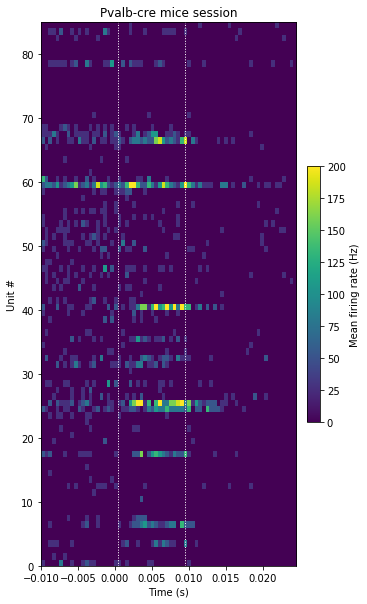

In [7]:
def plot_optotagging_response(da):

    plt.figure(figsize=(5,10))
    
    # Plot mean firing rate of each unit across each trial
    plt.imshow(da.mean(dim='trial_id').T / time_resolution, 
               extent=[np.min(bin_edges), np.max(bin_edges),
                       0, len(VISp_df)],
               aspect='auto', vmin=0, vmax=200)    
    
    # Plot Vertical lines indicating stimulus window 
    for bound in [0.0005, 0.0095]:
        plt.plot([bound, bound],[0, len(VISp_df)], ':', color='white', linewidth=1.0)

    plt.xlabel('Time (s)')
    plt.ylabel('Unit #')

    cb = plt.colorbar(fraction=0.046, pad=0.04)
    cb.set_label('Mean firing rate (Hz)')
    
plot_optotagging_response(da)
plt.title('Pvalb-cre mice session')
plt.show()

A good way to use this data would be to comapare the baseline firing rate (i.e. firing rate before stimulus) to the evoked firing rate. We can do this by first slicing our time bins into two timeframes, `baseline` and `evoked`. The `baseline` timeframe will begin at the start of our time bins and end just before the stimulus onset. The `evoked` timeframe will begin immidiatley after the onset of the stimulus and end right before the end of the stimulus suration. 

We will then reduce our data to only the mean firing rate of each unit within each time frame.

In [8]:
# Assign time before stimulus occurs
baseline = da.sel(time_relative_to_stimulus_onset=slice(-0.01,-0.002))

# Calculate Mean firing rate of each unit for time before the stimulus window 
baseline_rate = baseline.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008

# Assign time within stimulus window
evoked = da.sel(time_relative_to_stimulus_onset=slice(0.001,0.009))

# Calculate Mean firing rate of each unit for time within the stimulus window 
evoked_rate = evoked.sum(dim='time_relative_to_stimulus_onset').mean(dim='trial_id') / 0.008

evoked_rate

<xarray.DataArray 'spike_counts' (unit_id: 85)>
array([  1.66666667,  10.        ,   0.        ,   0.        ,
         0.        ,   0.        ,  18.33333333,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   1.66666667,   0.        ,
         6.66666667,  33.33333333,  71.66666667,   0.        ,
         0.        ,   1.66666667,   0.        ,   0.        ,
        10.        , 110.        ,  10.        ,   1.66666667,
         3.33333333,   1.66666667,   6.66666667,   5.        ,
         1.66666667,   5.        ,   8.33333333,   6.66666667,
         1.66666667,   0.        ,  11.66666667,   3.33333333,
         1.66666667,   5.        ,   1.66666667,   3.33333333,
       110.        ,  10.        ,   5.        ,   0.        ,
         3.33333333,  28.33333333,   1.66666667,   1.66666667,
        30.        ,  28.33333333,   1.66666667,   0.        ,
        11.66666667,   1.66666667,   8.33333333, 131.66666667,
        61.66666667,   1.66666667,   0.        ,   3.33333333,
         0.        ,   0.        ,   0.        ,  60.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         1.66666667,   0.        ,   3.33333333,   0.        ,
         0.        ,  11.66666667,  48.33333333,   0.        ,
         0.        ,  26.66666667,   0.        ,   0.        ,
         5.        ])
Coordinates:
  * unit_id  (unit_id) int64 951091330 951091321 ... 951093594 951093093

We now have two DataArrays, one that contains the mean firing rate of the units at baseline, and one that contains the mean firing rate of the units during the pulse. Plotting a scatter plot with these two areas will show us how a unit's basline firing rate compares to its evoked firing rate. 

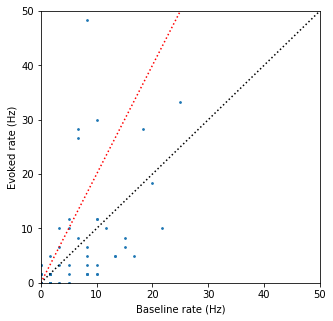

In [9]:
plt.figure(figsize=(5,5))

plt.scatter(baseline_rate, evoked_rate, s=3)

axis_limit = 50

# Black line though center represents no change in rate (1:1)
plt.plot([0,axis_limit],[0,axis_limit], ':k')

# Red line represents a 2x change in rate (2:1)
plt.plot([0,axis_limit],[0,axis_limit*2], ':r')

plt.xlim([0,axis_limit])
plt.ylim([0,axis_limit])

plt.xlabel('Baseline rate (Hz)')
_ = plt.ylabel('Evoked rate (Hz)')

Each point represent a neural unit. The black line represents a 1:1 ratio in the evoked firing rate to the baseline firing rate of that unit. Any unit below that black line had a larger response at baseline than it did to the light pulse. The red line represents a 2:1 ratio in the evoked firing rate to the baseline firing rate of that unit. We can subselect units whose evoked firing rate is 2x larger than baseline to define the cre+ units.

## Identifying Fast-Paced Waveforms

Defining what units are cre+ from those that are cre- is the first step in comparing optogenetic responses. Below we will create two lists, one with IDs of units who had an evoked firing rate 2x greater than baseline, and one with IDs of units whose evoked response was smaller than 2x the baseline. 

In [10]:
# Return units whose firing rates doubled when light was on
cre_pos_units = da.unit_id[(evoked_rate / (baseline_rate + 1)) > 2].values # add 1 to prevent divide-by-zero errors

# also get cre neg units
cre_neg_units = da.unit_id[(evoked_rate / (baseline_rate + 1)) < 2].values

print("Pvalv+ Cre lines")
print(cre_pos_units)

print(' \n Pvalb- Cre lines')
print(cre_neg_units)

Pvalv+ Cre lines
[951091685 951091848 951093460 951092078 951092169 951092262 951092354
 951092425 951092652 951093560 951092943 951093075]
 
 Pvalb- Cre lines
[951091330 951091321 951091400 951091392 951091381 951091372 951091461
 951091434 951091443 951091568 951091559 951091521 951091541 951091588
 951091638 951091630 951091614 951091707 951091771 951091726 951093445
 951091780 951091808 951091825 951091866 951091832 951091891 951091884
 951091875 951091978 951091953 951091926 951091916 951091908 951091997
 951091944 951092220 951091969 951092061 951092188 951092085 951092203
 951092070 951093476 951092210 951092162 951093487 951092245 951092237
 951092370 951092333 951092339 951092289 951092530 951092523 951092506
 951093505 951092575 951092671 951093540 951093533 951093514 951092679
 951092765 951092815 951093549 951092917 951092717 951092925 951093061
 951093031 951093594 951093093]


Lets take a look at the wavefroms of cre+ units and see how they compare to cre- units. 

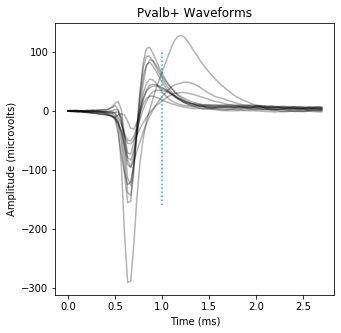

In [11]:
plt.figure(figsize=(5,5))

for unit_id in cre_pos_units:
    
    peak_channel = session.units.loc[unit_id].peak_channel_id
    wv = session.mean_waveforms[unit_id].sel(channel_id = peak_channel)
    
    plt.plot(wv.time * 1000, wv, 'k', alpha=0.3)

plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (microvolts)')
plt.title('Pvalb+ Waveforms')
plt.plot([1.0, 1.0],[-160, 100],':c')
plt.show()

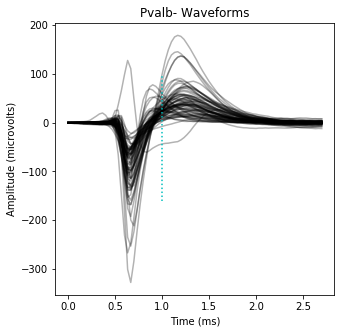

In [12]:
plt.figure(figsize=(5,5))

for unit_id in cre_neg_units:
    
    peak_channel = session.units.loc[unit_id].peak_channel_id
    wv = session.mean_waveforms[unit_id].sel(channel_id = peak_channel)
    
    plt.plot(wv.time * 1000, wv, 'k', alpha=0.3)

plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (microvolts)')
plt.title('Pvalb- Waveforms')
plt.plot([1.0, 1.0],[-160, 100],':c')
plt.show()